In [18]:
import BIDS_io, leave_one_out_CV, rewrite_int_data, settings, write_BIDS_from_mat
from matplotlib import pyplot as plt
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from settings import Settings
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from scipy import signal, stats

### ICN - Movement decoding toolbox 

The provided toolbox implements functionality to 
 - read raw BIDS data 
 - basic signal preprocessing functions (running z-scoring/time frequency analysis)
 - read BIDS coordinate files 
 - interpolation of raw coordinate channels to a common proved grid 
 - Cross Validation based analysis to test Machine Learning models on a common localization grid

#### settings specifies the used BIDS folder

In [2]:
settings.BIDS_path

'/Users/hi/Documents/workshop_ML/thesis_plots/BIDS/'

#### all BrainVision filenames are read

In [3]:
vhdr_filename_paths = Settings.read_all_vhdr_filenames()

For the following run in vhdr_filename_paths[0], the data analysis pipeline is presented:
 - read raw BIDS file
 - extract the label vectors
 - time frequency transform the data, s.t. it resembles in array with shape (f_bands, channels, time)
 - do z-scoring for every channel and band respectively 
 - (calculate the variance over a running window) 

#### given a file path, the raw BrainVision files are read with BIDS_io.read_BIDS_file(file_path)

In [4]:
file_path = vhdr_filename_paths[0]

In [5]:
bv_raw, ch_names = BIDS_io.read_BIDS_file(file_path)
mov_label = bv_raw[-2:, :]  # last two elements are labels

Extracting parameters from /Users/hi/Documents/workshop_ML/thesis_plots/BIDS/sub-000/ses-right/eeg/sub-000_ses-right_task-force_run-0_eeg.vhdr...
Setting channel info structure...


#### time frequency transform using digital FIR filter

In [6]:
x_filtered = BIDS_io.transform_channels(bv_raw)

#### every frequency band for every channel is z-scored

In [7]:
# proxy for offline data analysis
x_filtered_zscored = BIDS_io.z_score_offline(x_filtered)
mov_label_zscored = BIDS_io.z_score_offline_label(mov_label)

# online real time z-scoring
# x_filtered_zscored = running_z_score(x_filtered, z_score_running_interval)
# mov_label_zscored = running_zscore_label(mov_label, z_score_running_interval)  # does not yield desired results...

In [8]:
x_filtered_zscored.shape  # 8 frequency bands, 6 channels

(8, 6, 130001)

In [9]:
mov_label_zscored.shape  # 0 - contralateral, 1 - ipsialteral

(2, 130001)

/Users/hi/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


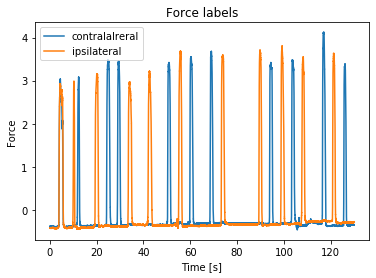

In [10]:
plt.plot(np.arange(mov_label_zscored[0,:].shape[0])/settings.sample_rate, \
         mov_label_zscored[0,:], label='contralalreral')
plt.plot(np.arange(mov_label_zscored[1,:].shape[0])/settings.sample_rate, \
         mov_label_zscored[1,:], label='ipsilateral')
plt.title('Force labels')
plt.xlabel('Time [s]')
plt.ylabel('Force')
plt.legend()
plt.show()

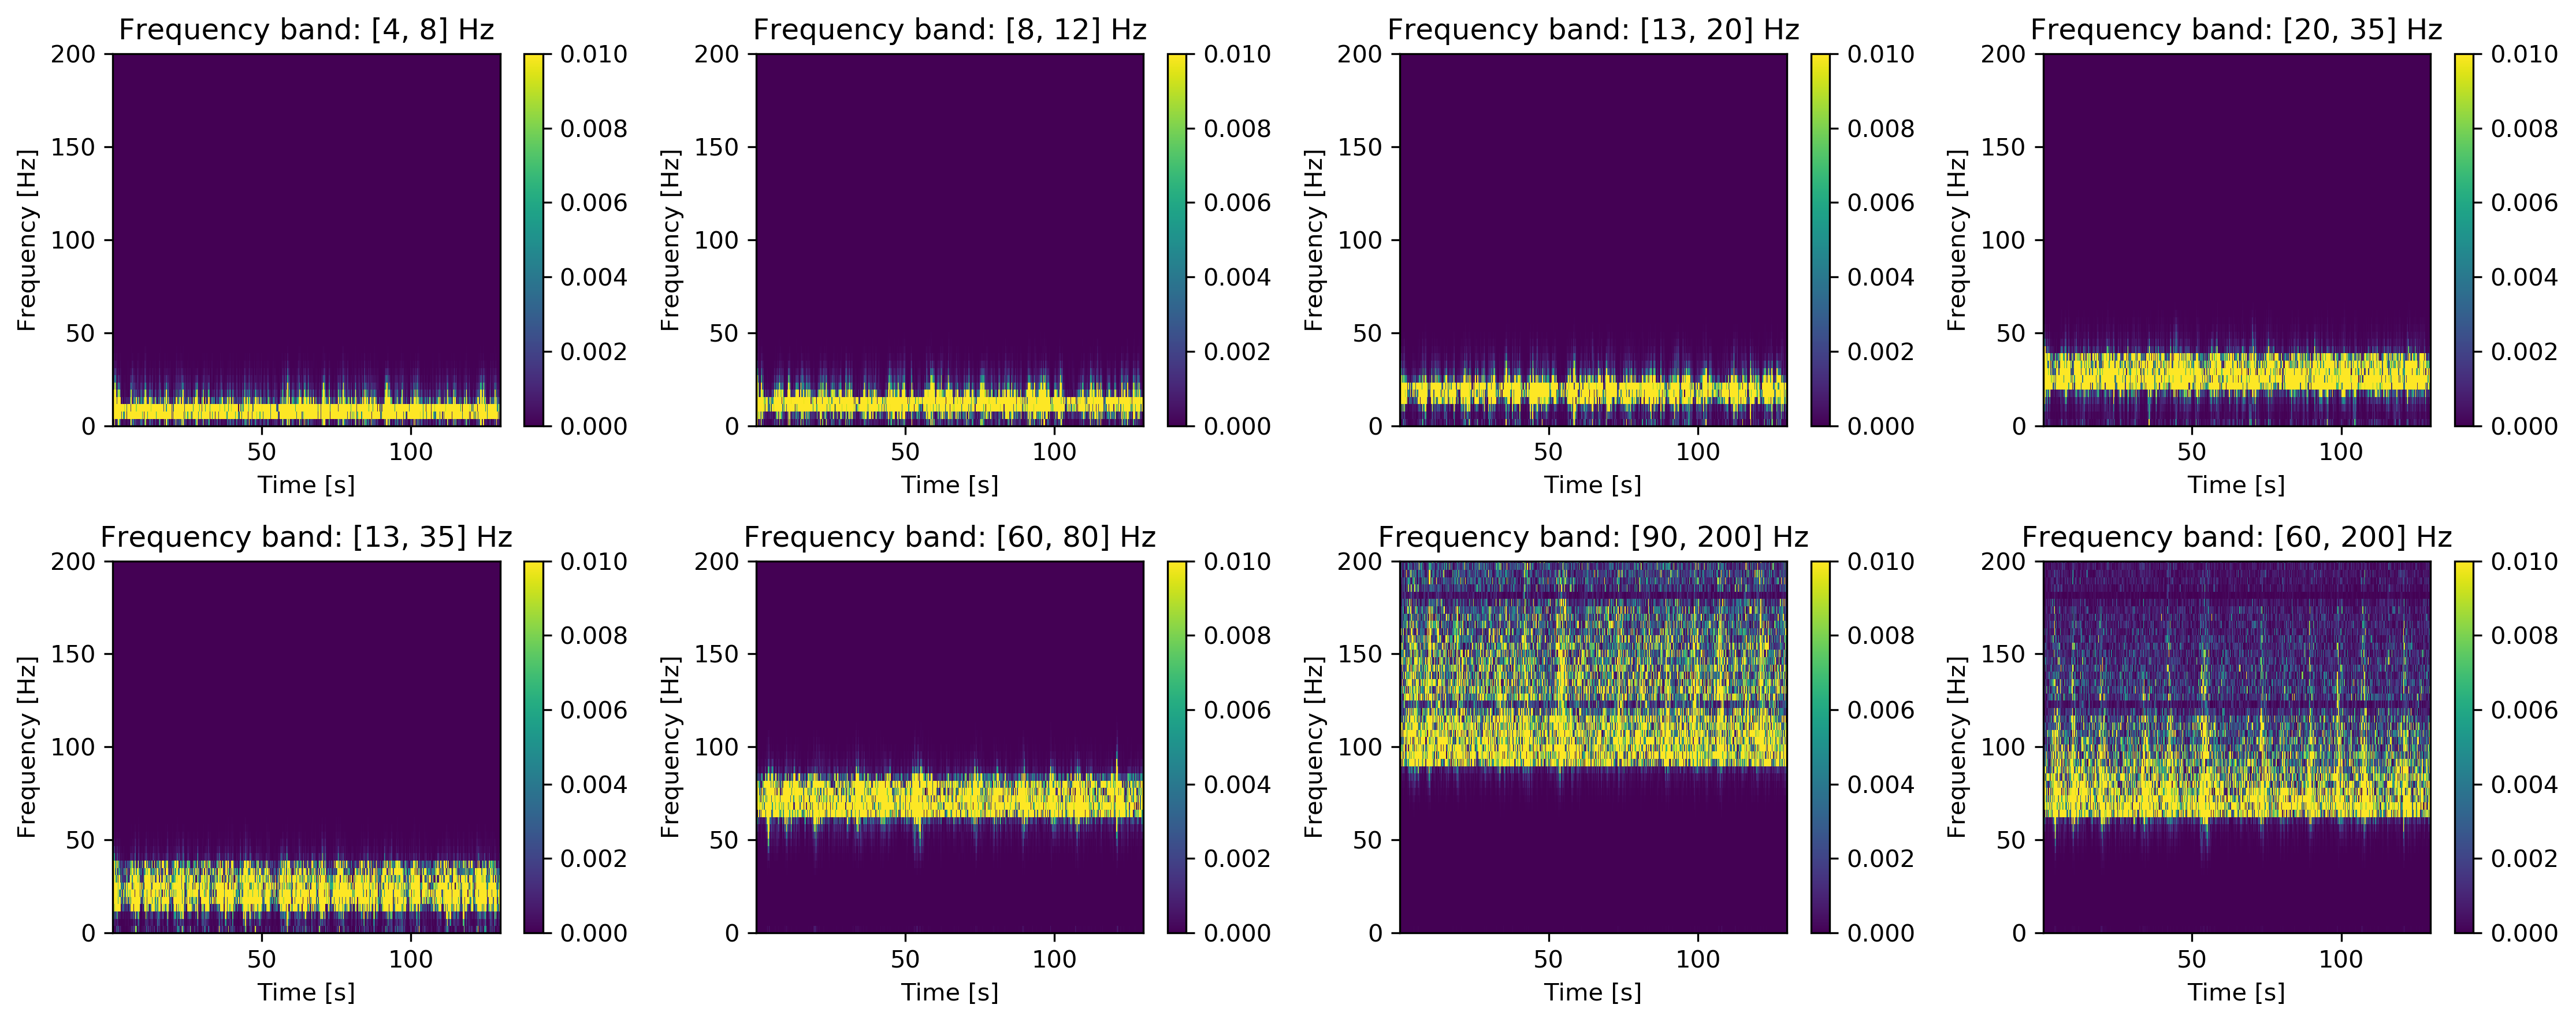

In [11]:
#Frequency bands
plt.figure(figsize=(15,6), dpi=300)
for f_idx in range(len(settings.f_ranges)):
    f, t, Sxx = sp.signal.spectrogram(x_filtered_zscored[f_idx,0,:], settings.sample_rate)
    plt.subplot(2,4,f_idx+1)
    plt.pcolormesh(t, f, Sxx); plt.ylim(0,200)
    plt.title('Frequency band: '+str(settings.f_ranges[f_idx])+' Hz')
    plt.xlabel('Time [s]'); plt.ylabel('Frequency [Hz]')
    plt.colorbar()
    plt.clim(0, 0.01)
plt.tight_layout()

#### the variance is taken wrt to a moving window with size settings.var_rolling_window

In [13]:
x_filtered_zscored, mov_label_zscored = BIDS_io.calc_running_var(x_filtered_zscored, mov_label_zscored, \
                                                                 var_interval=1000)

In [14]:
# clipping for artifact rejection
x_filtered_zscored = np.clip(x_filtered_zscored, settings.clip_low, settings.clip_high)

#### it somehow messes up the spectra...

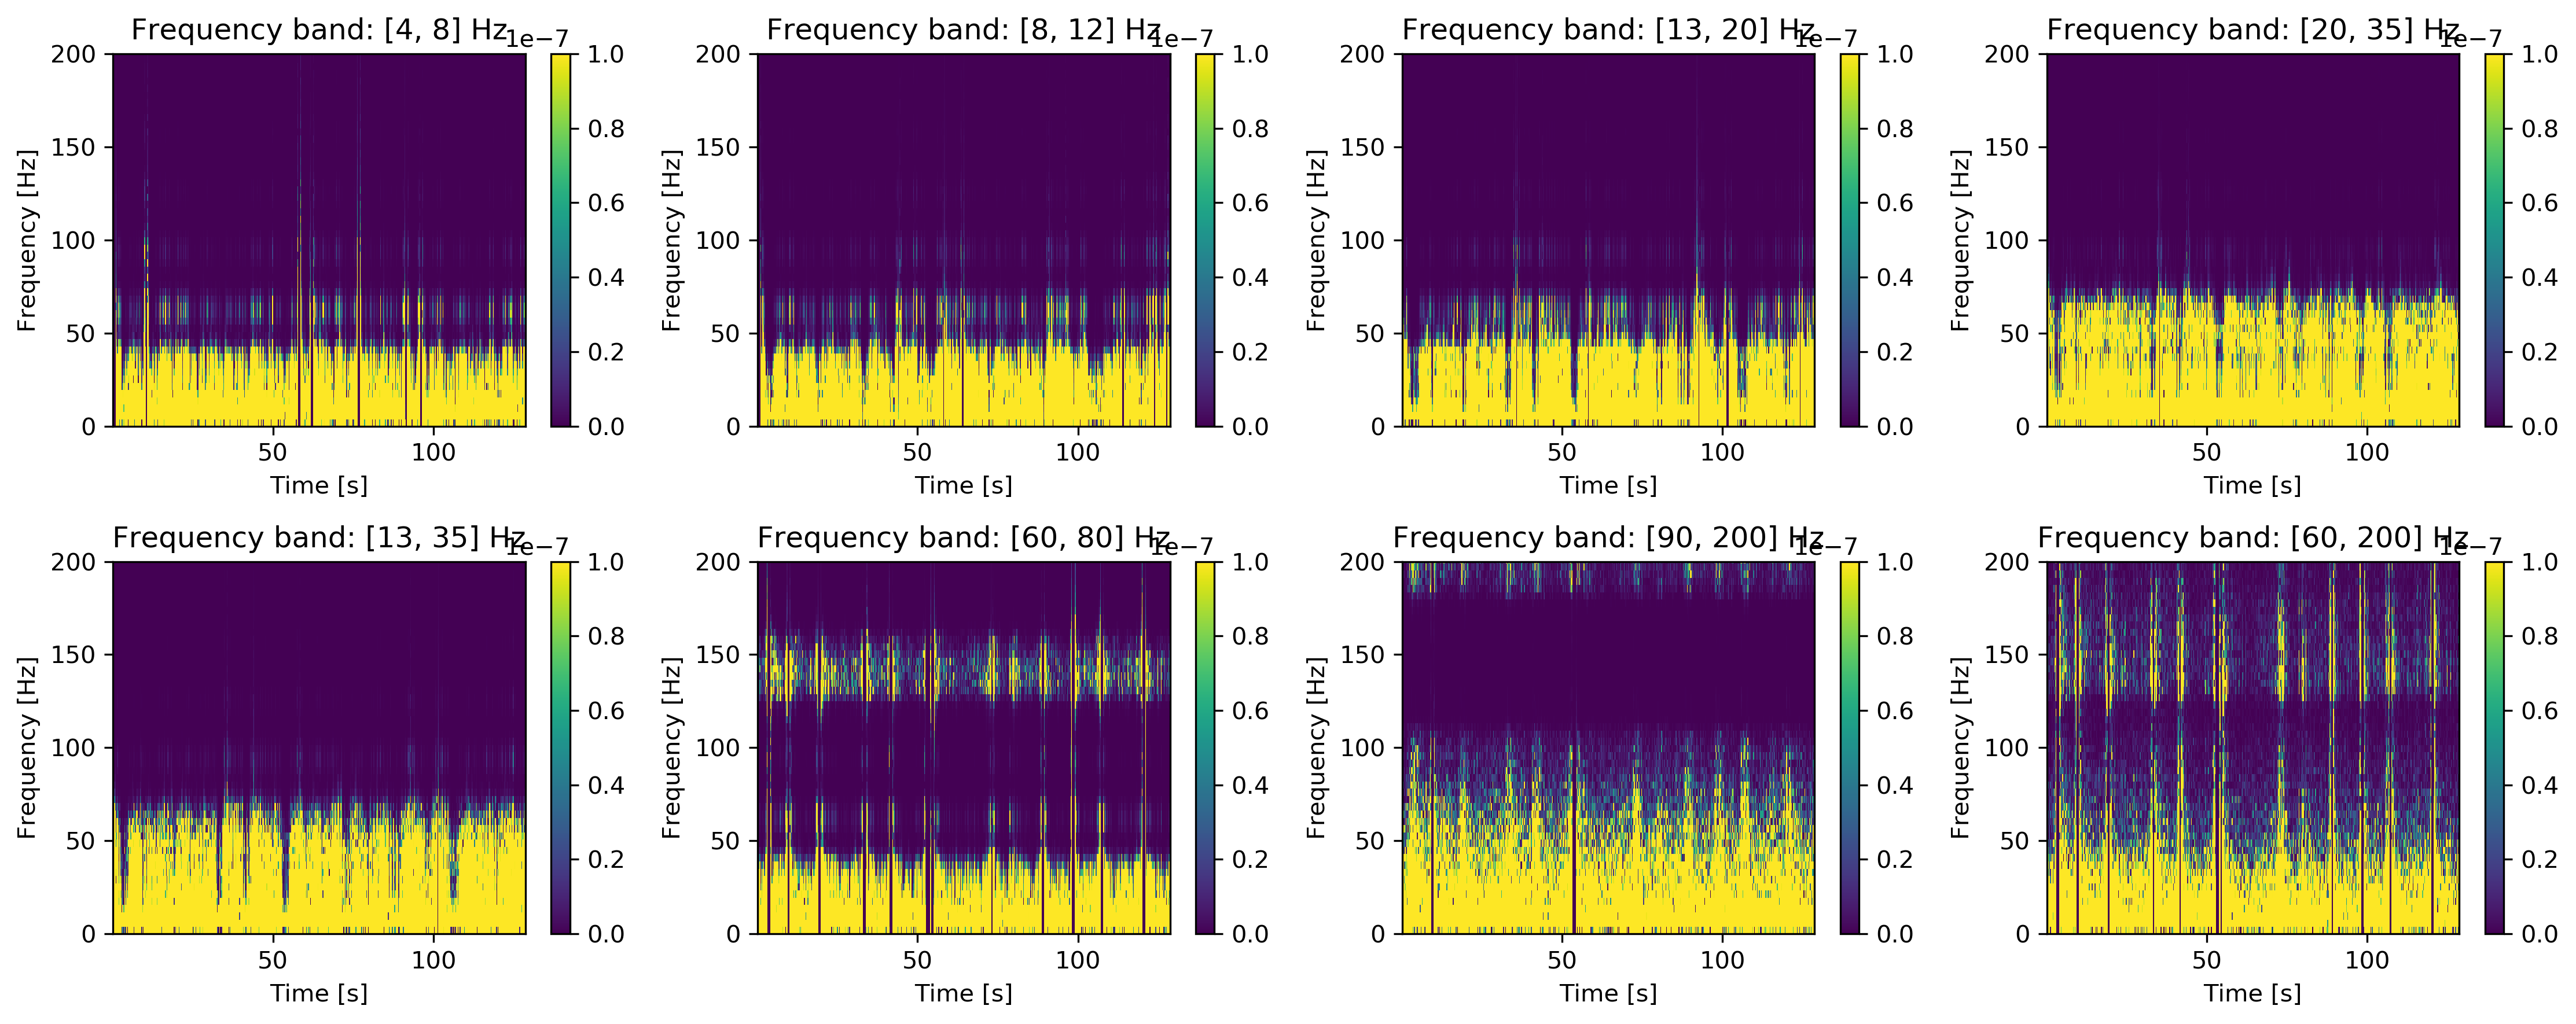

In [17]:
#the running variance results in the following spectra: 
plt.figure(figsize=(15,6), dpi=300)
for f_idx in range(len(settings.f_ranges)):
    f, t, Sxx = sp.signal.spectrogram(x_filtered_zscored[f_idx,0,:], settings.sample_rate)
    plt.subplot(2,4,f_idx+1)
    plt.pcolormesh(t, f, Sxx); plt.ylim(0,200)
    plt.title('Frequency band: '+str(settings.f_ranges[f_idx])+' Hz')
    plt.xlabel('Time [s]'); plt.ylabel('Frequency [Hz]')
    plt.colorbar()
    plt.clim(0, 0.0000001)
plt.tight_layout()

The variance is changing the respective frequency band spectra. 
The following feature preprocessing(FIR Filtering, z-scoring, variance calculation in a given time window) results for a Linear Regression in the following 5 fold CV in the following r2_scores:

In [19]:
cross_val_score(LinearRegression(), x_filtered_zscored[:, 5,:].T, mov_label_zscored[1,:], cv=5)

array([0.38979848, 0.81906138, 0.1737775 , 0.61201227, 0.58018856])

#### Read BIDS coordinate array from every subject and every run in shape (patient_idx, [ECoG left, STN left, ECoG right, STN right])

In [20]:
coord_arr, coord_arr_names = Settings.read_BIDS_coordinates()

/Users/hi/Documents/workshop_ML/thesis_plots/BIDS/sub-000/ses-left/eeg/sub-000_electrodes.tsv
/Users/hi/Documents/workshop_ML/thesis_plots/BIDS/sub-000/ses-right/eeg/sub-000_electrodes.tsv
/Users/hi/Documents/workshop_ML/thesis_plots/BIDS/sub-001/ses-left/eeg/sub-001_electrodes.tsv
/Users/hi/Documents/workshop_ML/thesis_plots/BIDS/sub-001/ses-right/eeg/sub-001_electrodes.tsv
/Users/hi/Documents/workshop_ML/thesis_plots/BIDS/sub-002/ses-left/eeg/sub-002_electrodes.tsv
/Users/hi/Documents/workshop_ML/thesis_plots/BIDS/sub-002/ses-right/eeg/sub-002_electrodes.tsv
/Users/hi/Documents/workshop_ML/thesis_plots/BIDS/sub-003/ses-left/eeg/sub-003_electrodes.tsv
/Users/hi/Documents/workshop_ML/thesis_plots/BIDS/sub-003/ses-right/eeg/sub-003_electrodes.tsv
/Users/hi/Documents/workshop_ML/thesis_plots/BIDS/sub-004/ses-left/eeg/sub-004_electrodes.tsv
/Users/hi/Documents/workshop_ML/thesis_plots/BIDS/sub-004/ses-right/eeg/sub-004_electrodes.tsv
/Users/hi/Documents/workshop_ML/thesis_plots/BIDS/sub-0

In [21]:
coord_arr.shape

(17, 4)

#### channels names are stored in the same shape

In [22]:
coord_arr_names[0]

array([None,
       list(['ECOG_RIGHT_0', 'ECOG_RIGHT_1', 'ECOG_RIGHT_2', 'ECOG_RIGHT_3', 'ECOG_RIGHT_4', 'ECOG_RIGHT_5', 'STN_RIGHT_0', 'STN_RIGHT_1', 'STN_RIGHT_2', 'STN_RIGHT_3'])],
      dtype=object)

In [23]:
ecog_grid_left, ecog_grid_right, stn_grid_left, stn_grid_right = Settings.define_grid()

In [24]:
grid_ = [ecog_grid_left, stn_grid_left, ecog_grid_right, stn_grid_right]

Text(0.5, 0.92, 'grid matrix')

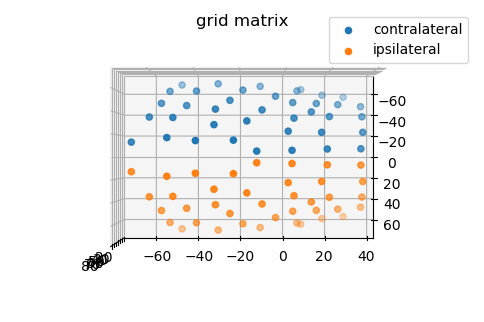

In [25]:
fig = plt.figure(dpi=100)
ax = fig.add_subplot(111, projection='3d')
ax.scatter(ecog_grid_left[0,:], ecog_grid_left[1,:],ecog_grid_left[2,:], zdir='z', s=20, c=None, depthshade=True, label='contralateral')
ax.scatter(ecog_grid_right[0,:], ecog_grid_right[1,:],ecog_grid_right[2,:], zdir='z', s=20, c=None, depthshade=True, label='ipsilateral')

ax.view_init(azim=0, elev=90)
plt.legend()
plt.title('grid matrix')

Text(0.5, 0.92, 'STN grid')

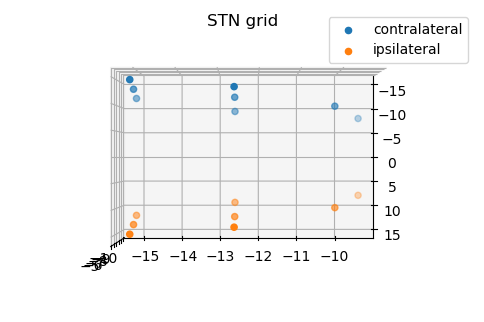

In [26]:
fig = plt.figure(dpi=100)
ax = fig.add_subplot(111, projection='3d')
ax.scatter(stn_grid_left[0,:], stn_grid_left[1,:],stn_grid_left[2,:], zdir='z', s=20, c=None, depthshade=True, label='contralateral')
ax.scatter(stn_grid_right[0,:], stn_grid_right[1,:],stn_grid_right[2,:], zdir='z', s=20, c=None, depthshade=True, label='ipsilateral')
ax.view_init(azim=0, elev=90)
plt.legend()
plt.title('STN grid')

#### Raw Electrode Positions 

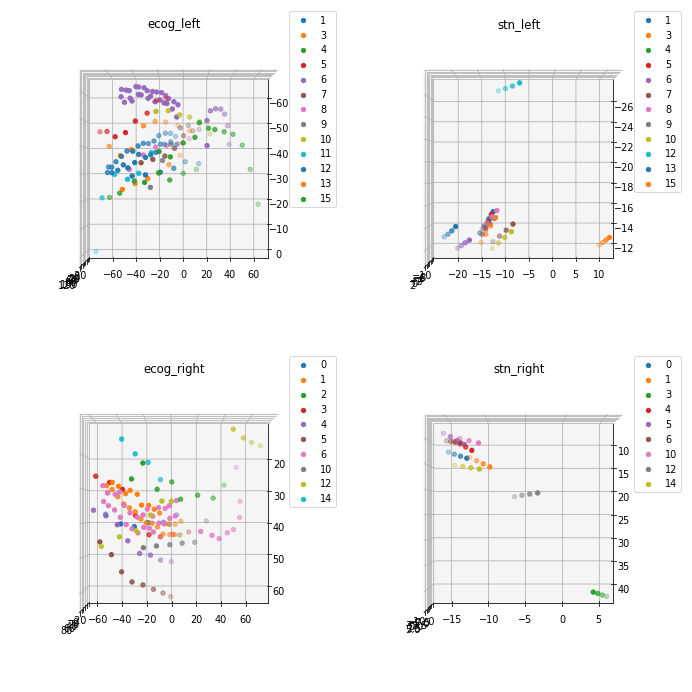

In [27]:
fig = plt.figure(figsize=(10,10), dpi=70)
index_ = ['ecog_left', 'stn_left', 'ecog_right', 'stn_right']
for index in range(4):# 
    ax = fig.add_subplot(2,2,index+1, projection='3d')

    for patient_idx in range(16):
        if coord_arr[patient_idx,index] is not None:
            ax.scatter(coord_arr[patient_idx,index][:,0], coord_arr[patient_idx,index][:,1], \
                   coord_arr[patient_idx,index][:,2], zdir='z', s=20, c=None, depthshade=True, label=patient_idx)
    ax.view_init(azim=0, elev=90)
    ax.legend()
    ax.set_title(index_[index])
plt.tight_layout()

#### Interpolation

In [28]:
subject_idx, file_name_out = BIDS_io.get_name(file_path)

matrix_arr = BIDS_io.calc_projection_matrix(subject_idx, coord_arr, grid_)

int_data, label_mov, act_grid_points = BIDS_io.interpolate_stream(x_filtered_zscored, mov_label_zscored,
                                                          matrix_arr, subject_idx, ch_names,
                                                          int_distance_ecog=settings.int_distance_ecog,
                                                          int_distance_stn=settings.int_distance_stn)


Text(0.5, 1.0, 'distance matrix used for interpolation')

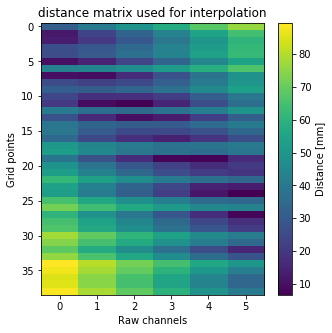

In [29]:
plt.figure(figsize=(5,5))
plt.imshow(matrix_arr[2], aspect='auto')
cbar = plt.colorbar()
cbar.set_label('Distance [mm]')
plt.xlabel('Raw channels')
plt.ylabel('Grid points')
plt.title('distance matrix used for interpolation')

#### interpolated data is stored in numpy array with shape (grid_points)

In [30]:
int_data.shape

(94,)

#### each of these indices comprising shape (frequency bands x time)

In [31]:
int_data[1].shape

(8, 129002)

#### the label vector is equally setup with shape (contralateral/ipsialteral, time)

In [32]:
label_mov.shape

(2, 129002)

#### act_grid_points comprises a binary array with 1 indices for active interpolated grid points

In [33]:
act_grid_points.shape

(94,)

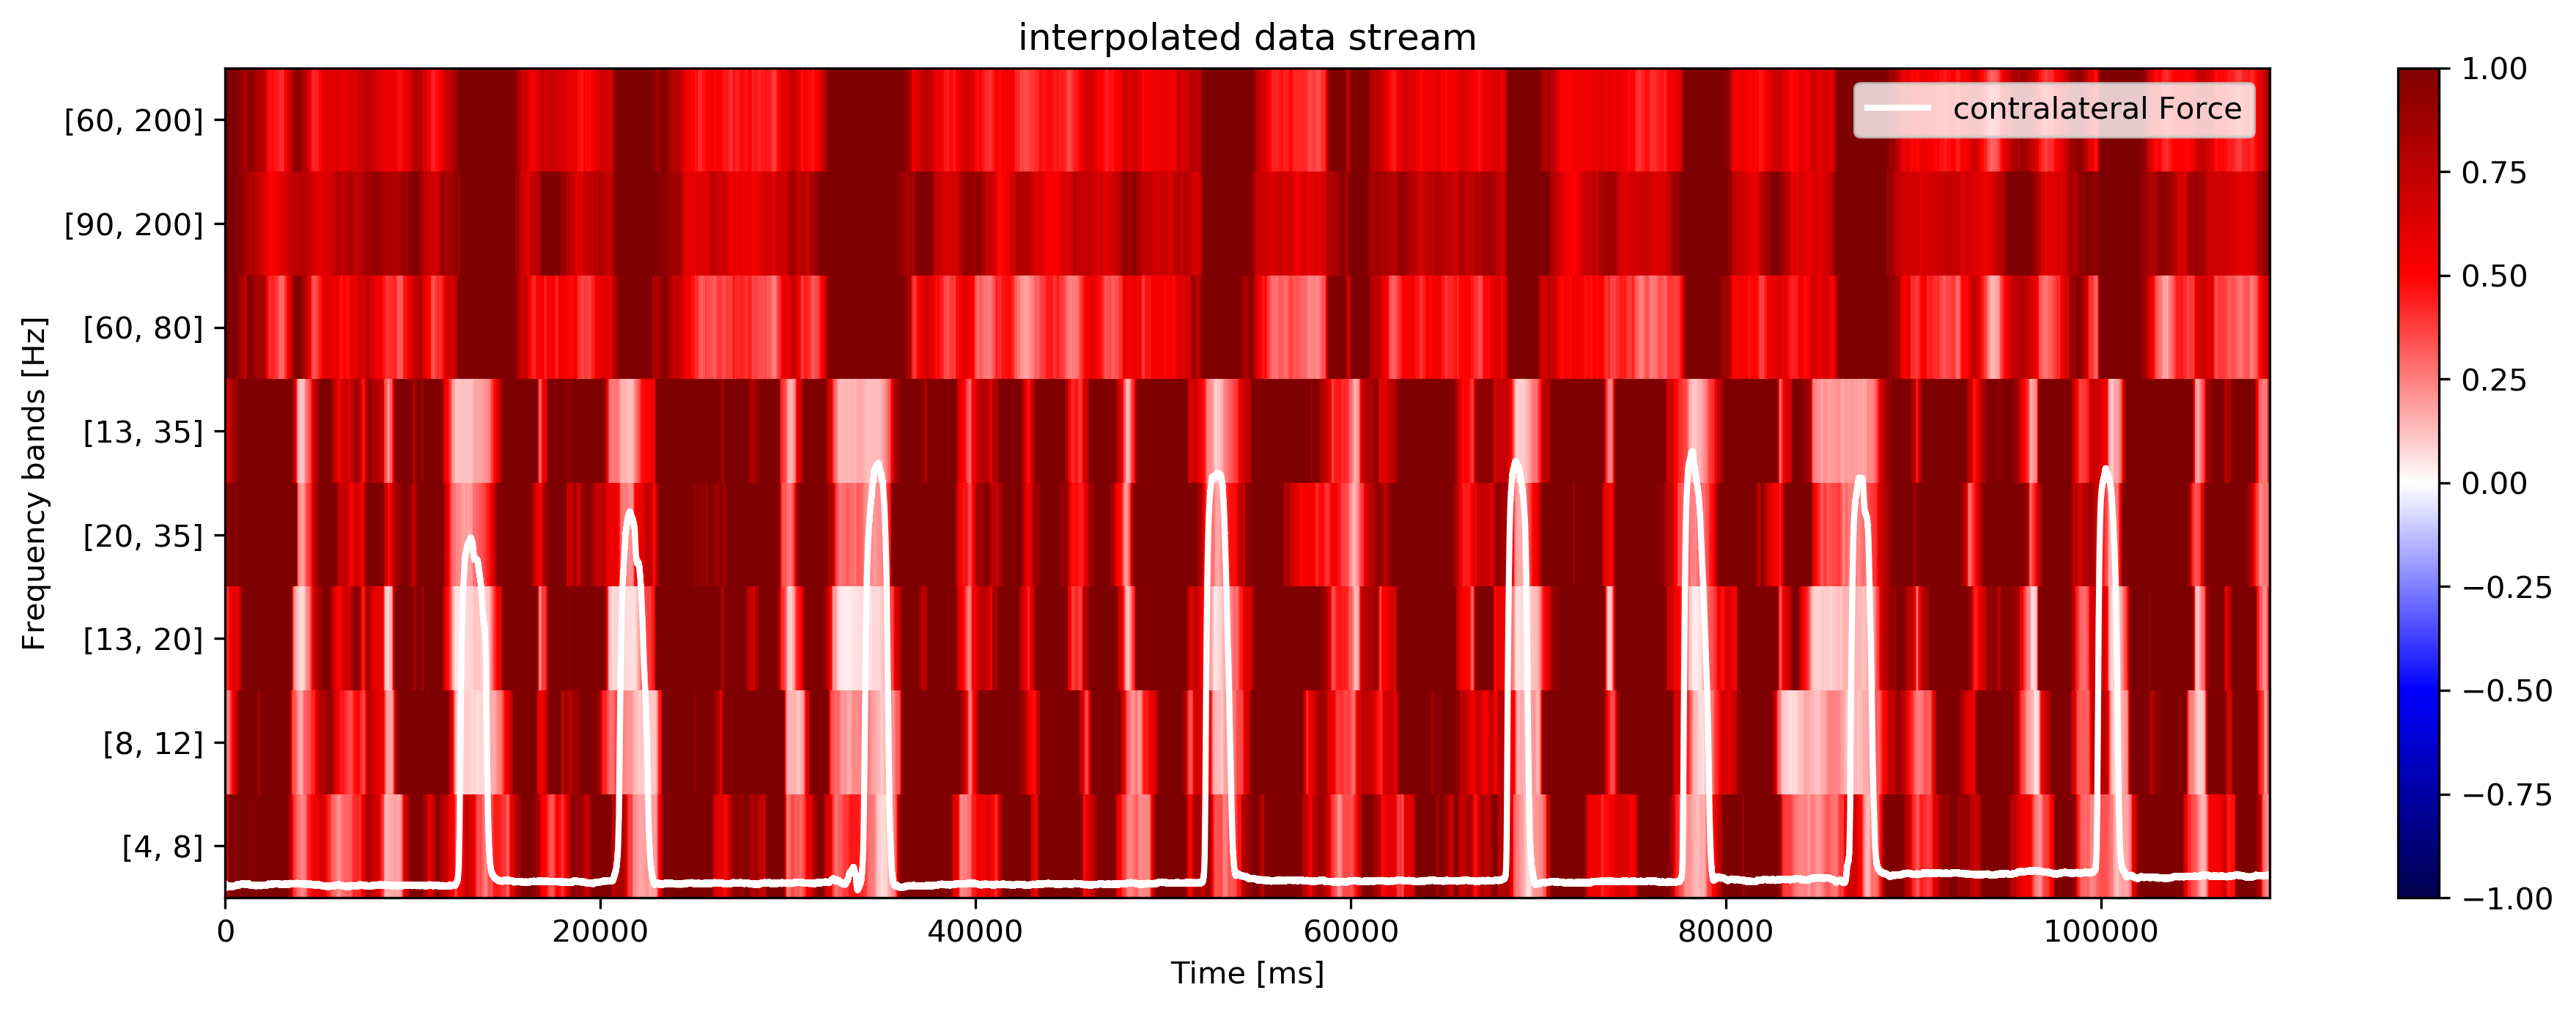

In [34]:
start_ = 20000; end_ = 150000
plt.figure(figsize=(15,5), dpi=300)
plt.imshow(int_data[1][:,start_:end_], aspect='auto', cmap='seismic')
plt.yticks(np.arange(8), settings.f_ranges)
plt.plot(label_mov[0,start_:end_], color='white', label='contralateral Force', linewidth=2)
plt.gca().invert_yaxis()
plt.colorbar()
plt.xlabel('Time [ms]')
plt.ylabel('Frequency bands [Hz]')
plt.title('interpolated data stream')
plt.legend()
plt.clim(-1,1)

#### Cross Validation

For Cross Validation data from get_train_test_dat in leave_one_out_CV reads for the respective grid_point all runs for every patient except patient_test

if Train=False, it returns the concatenates run data only for patient_test

act_.npy is written by leave_one_out_CV.save_all_act_grid_points(), which reads all active grid points for every run of every patient, and saves it as a numpy file

In [35]:
patient_test = 0
grid_point = 1
act_ = np.load('act_.npy', allow_pickle=True)

In [36]:
dat, label = leave_one_out_CV.get_train_test_dat(patient_test, grid_point, act_, Train=True)

In [37]:
dat.shape

(8, 111632)

In [38]:
label.shape

(111632,)

In [39]:
act_[patient_test].shape

(4, 94)

patient_test has 4 runs

In [40]:
np.nonzero(act_[patient_test][1,:])

(array([ 1,  2,  5,  7, 10, 11, 13, 16, 19, 20, 21, 23, 24, 27, 28, 32, 40,
        41, 44, 46, 49, 50, 52, 55, 58, 59, 60, 62, 63, 66, 67, 71]),)

In [41]:
dat, label = leave_one_out_CV.get_train_test_dat(patient_test, grid_point, act_, Train=False)

In [42]:
dat.shape

(8, 7574)

In [43]:
label.shape

(7574,)

#### due to the high sampling frequency of 1kHz, data can be downsampled

In [ ]:
rewrite_int_data.downsample_data(downsample_rate = 100)

#### function leave_one_out_CV.run_CV(patient_test, model_fun = RandomForestRegressor) runs the whole CV using the function above

The output of performed Cross Validation is saved in settings.out_path_folder

This can be efficiently done using a multiprocessing tool

In [ ]:
import multiprocessing

In [ ]:
pool = multiprocessing.Pool()
pool.map(leave_one_out_CV.run_CV, np.arange(16))